In [38]:
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation
import numpy as np
from qat.core import Observable, Term
import numpy as np
import scipy
from numpy import binary_repr
from qat.fermion import ElectronicStructureHamiltonian
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ, I
from qat.core import Observable, Term, Circuit
from qat.lang.AQASM.gates import Gate
import matplotlib as mpl
import numpy as np
from typing import Optional, List
import warnings

In [39]:
import numpy as np
from qat.core import Observable, Term
import numpy as np
import scipy
from numpy import binary_repr
from qat.fermion import ElectronicStructureHamiltonian
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ, I, X
from qat.core import Observable, Term, Circuit
from qat.lang.AQASM.gates import Gate
import matplotlib as mpl
import numpy as np
from typing import Optional, List
import warnings
from qat.qpus import get_default_qpu

qpu = get_default_qpu()
method = "BFGS"



def ising(N):
    np.random.seed(123)  

    terms = []

    # Generate random coefficients for the transverse field term (X)
    a_coefficients = np.random.random(N)
    for i in range(N):
        term = Term(coefficient=a_coefficients[i], pauli_op="X", qbits=[i])
        terms.append(term)

    # Generate random coefficients for the interaction term (ZZ)
    J_coefficients = np.random.random((N, N))
    for i in range(N):
        for j in range(i):
            if i != j:  # avoid duplicate terms
                term = Term(coefficient=J_coefficients[i, j], pauli_op="ZZ", qbits=[i, j])
                terms.append(term)
    ising = Observable(N, pauli_terms=terms, constant_coeff=0.0)
    return ising


def Molecule_Generator(model):
    if model == "H2":
        r = 0.98
        geometry = [("H", (0, 0, 0)), ("H", (0, 0, r))]
        charge = 0
        spin = 0
        basis = "sto-3g"
    
    elif model == "H4":
        r = 0.85
        geometry = [
            ("H", (0, 0, 0)),
            ("H", (0, 0, 1 * r)),
            ("H", (0, 0, 2 * r)),
            ("H", (0, 0, 3 * r)),
        ]
        charge = 0
        spin = 0
        basis = "sto-3g"
  
    return r, geometry, charge, spin, basis

# Define the the curcuit that we want to use


def circuit_ansatz(nqbits,k, depth, theta_list):
    
    """Returns hardware efficient ansatz circuit.

    Args:
        n_qubit (:class:`int`):
            the number of qubit used (equivalent to the number of fermionic modes)
        depth (:class:`int`):
            depth of the circuit.
        theta_list (:class:`numpy.ndarray`):
            rotation angles.
    Returns:
        :circuit`
    """
    prog = Program()
    reg = prog.qalloc(nqbits)

    state = binary_repr(k)
    state_pad = state.zfill(nqbits)
    state_lst = [int(c) for c in state_pad]


    for j in range(min(nqbits, len(state_lst))):
        if int(state_lst[j] == 1):
            prog.apply(X, reg[j])
        
        if int(state_lst[j] == 0):
            prog.apply(I, reg[j])
    
    print("This applied state is ", state_pad)

    prog.apply(RY(theta_list[-2]), reg[0])
    prog.apply(RZ(theta_list[-1]), reg[0])

    for d in range(depth):
        
        for i in range(nqbits):
            prog.apply(RY(theta_list[2*i+2*nqbits*d]), reg[i])
            prog.apply(RZ(theta_list[2*i+1+2*nqbits*d]), reg[i])
        
        for i in range(nqbits//2):
            prog.apply(CNOT, reg[2*i+1], reg[2*i])
        
        for i in range(nqbits//2-1):
            prog.apply(CNOT, reg[2*i+2], reg[2*i+1])

    for i in range(nqbits):
        prog.apply(RY(theta_list[2*i+2*nqbits*depth]), reg[i])
        prog.apply(RZ(theta_list[2*i+1+2*nqbits*depth]), reg[i])

    return prog.to_circ()

from scipy.sparse.linalg import eigsh

def calculate_eigen_vectors(model, int):
    model_matrix_sp = model.get_matrix(sparse=True)
    eigenvalues, eigenvectors = eigsh(model.get_matrix(), k=int)
    print(eigenvalues)
    # Assuming eigenvalues and eigenvectors are obtained
    num_eigenvalues = len(eigenvalues)
    eigenvec_dict = {}

    # Loop through each eigenvalue and store its eigenvector
    for i in range(num_eigenvalues):
        eigenvector_key = f'ee{i}'
        eigenvector_value = eigenvectors[:, i]
        eigenvec_dict[eigenvector_key] = eigenvector_value

    # Now eigenvecToT will be a list containing all eigenvectors
    eigenvecToT = [eigenvec_dict[f'ee{i}'] for i in range(num_eigenvalues)]

    return eigenvecToT

# Example usage:
# Assuming 'your_model' is an instance of the model class you are using


method = "BFGS"

def get_statevector(result, nbqbits):

    statevector = np.zeros((2**nbqbits), np.complex128)
    for sample in result:
        statevector[sample.state.int] = sample.amplitude
    return statevector


def fun_fidelity(circ, eigenvectors, nbqbits):

    qpu = get_default_qpu()
    res = qpu.submit(circ.to_job())
    statevector = get_statevector(res, nbqbits)
    #print("statevector",statevector)
    fid = abs(np.vdot(eigenvectors, statevector)) ** 2
    return fid

def opt_funct(circuits, model, qpu, nqbits, eigenvecToT, energy_lists, fidelity_lists, weight):
    def input_funct(x):
        total_energy = 0
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            result = qpu.submit(bound_circ.to_job(observable=model))
            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)

            # Calculate fidelity
            fidelity = fun_fidelity(bound_circ, eigenvecToT[i], nqbits)
            fidelity_lists[f"fidelity_circ_{i}"][method].append(fidelity)

            total_energy += weight[i] * energy
        return total_energy

    def callback(x):
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            result = qpu.submit(bound_circ.to_job(observable=model))
            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)

            # Calculate fidelity
            fidelity = fun_fidelity(bound_circ, eigenvecToT[i], nqbits)
            fidelity_lists[f"fidelity_circ_{i}"][method].append(fidelity)

    return input_funct, callback



In [40]:
from model import * # this file.py import all the defined function to here .ipynb

In [41]:
#model = ising(4) 
#print("Transverse Ising Model:", model)

In [42]:
name = Molecule_Generator("H2")

In [43]:
r, geometry, charge, spin, basis = name
(
    rdm1,
    orbital_energies,
    nuclear_repulsion,
    n_elec,
    one_body_integrals,
    two_body_integrals,
    info,
) = perform_pyscf_computation(
    geometry=geometry, basis=basis, spin=spin, charge=charge, run_fci=True
)
print("Number of electrons = ", n_elec)
nqbits = rdm1.shape[0] * 2
print("Number of qubits before active space selection = ", nqbits)
# print("rdm1", rdm1)
# print(info)
print("Orbital energies = ", orbital_energies)
print("Nuclear repulsion = ", nuclear_repulsion)

Number of electrons =  2
Number of qubits before active space selection =  4
Orbital energies =  [-0.4908283   0.47080536]
Nuclear repulsion =  0.5399767458367347


In [44]:
from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo
from qat.fermion.transforms import transform_to_jw_basis

mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)
H = mol_h.get_electronic_hamiltonian()
hamiltonian_sp = transform_to_jw_basis(H)
print(hamiltonian_sp)

(-0.31538790473063794+0j) * I^4 +
(0.15749185582934633+0j) * (ZZ|[0, 1]) +
(0.1072934876552053+0j) * (ZZ|[0, 2]) +
(0.15617538348132448+0j) * (ZZ|[1, 2]) +
(0.15617538348132448+0j) * (ZZ|[0, 3]) +
(0.13943713589673473+0j) * (Z|[0]) +
(0.1072934876552053+0j) * (ZZ|[1, 3]) +
(0.13943713589673473+0j) * (Z|[1]) +
(0.04888189582611918+0j) * (XYYX|[0, 1, 2, 3]) +
(-0.04888189582611918+0j) * (XXYY|[0, 1, 2, 3]) +
(-0.04888189582611918+0j) * (YYXX|[0, 1, 2, 3]) +
(0.04888189582611918+0j) * (YXXY|[0, 1, 2, 3]) +
(0.16407160243062638+0j) * (ZZ|[2, 3]) +
(-0.13600541087956455+0j) * (Z|[2]) +
(-0.13600541087956455+0j) * (Z|[3])


#### Step 1: Compute the eigenvector with the defined model and k 

In [45]:
model = hamiltonian_sp
int = 14

eigenvec_input_tar = calculate_eigen_vectors(model, int)

print(eigenvec_input_tar)

[-1.10531794  0.53997675  0.52624985 -0.34365999 -0.58081898 -0.60084192
  0.06379356 -0.04309338 -0.60084192 -0.58081898 -0.04309338 -0.73471515
 -0.73471515 -0.73471515]
[array([-1.06430053e-16+1.03502459e-16j, -1.40738907e-17-1.29617207e-16j,
       -4.99302931e-17+3.01750309e-17j,  1.08337619e-01-1.30626062e-01j,
       -6.41362167e-17-4.38629001e-17j,  5.95125821e-18-1.43785181e-17j,
       -1.35644926e-16-1.31233099e-16j, -5.11251100e-17-5.37040607e-17j,
       -1.71274076e-16-6.28026732e-17j,  1.38304390e-16+9.62189791e-17j,
       -6.27179233e-17+1.50509562e-17j, -2.04636048e-17+1.23100596e-16j,
       -6.29123297e-01+7.58553670e-01j,  2.58528958e-17-2.83846101e-17j,
       -6.52718520e-18+6.48205909e-17j,  7.61042981e-17-1.34520219e-16j]), array([-6.52081278e-01+7.58149067e-01j,  3.92971940e-17+2.23103883e-16j,
        7.36859107e-17-4.53208855e-17j,  3.01300441e-16-4.03428832e-16j,
        3.33001829e-17+4.92859196e-17j,  4.74786153e-17-2.34908463e-17j,
        2.84372484e-17

In [46]:
print(eigenvec_input_tar[13])

[ 1.29514307e-17+3.45275332e-18j  6.02829808e-20+2.72493866e-18j
  1.53140684e-17-1.36980360e-18j  5.05103257e-18+3.73198704e-18j
  1.69610170e-16-2.21433592e-17j  1.83741182e-01-8.07048122e-01j
  2.16344347e-01-3.30965289e-01j  1.18887343e-16-6.43168465e-17j
 -6.15303950e-17+1.86871179e-17j  2.16344347e-01-3.30965289e-01j
  4.65229697e-02-7.89443788e-03j  9.90927112e-17-1.22184961e-16j
  5.80281936e-19-8.72012043e-19j  4.89756247e-17-3.28413674e-17j
 -4.61987061e-17-1.85091665e-18j  7.33884670e-18+6.61711536e-19j]


In [47]:
eigenvec_input_tar[0]print()

[-1.06430053e-16+1.03502459e-16j -1.40738907e-17-1.29617207e-16j
 -4.99302931e-17+3.01750309e-17j  1.08337619e-01-1.30626062e-01j
 -6.41362167e-17-4.38629001e-17j  5.95125821e-18-1.43785181e-17j
 -1.35644926e-16-1.31233099e-16j -5.11251100e-17-5.37040607e-17j
 -1.71274076e-16-6.28026732e-17j  1.38304390e-16+9.62189791e-17j
 -6.27179233e-17+1.50509562e-17j -2.04636048e-17+1.23100596e-16j
 -6.29123297e-01+7.58553670e-01j  2.58528958e-17-2.83846101e-17j
 -6.52718520e-18+6.48205909e-17j  7.61042981e-17-1.34520219e-16j]


In [48]:
eigenvec_input = [eigenvec_input_tar[0], eigenvec_input_tar[13]] # So in here they are for the case k = 0 and 12 so it will come inside to the eigenvec_input[i] in the optimizer 
print(eigenvec_input)
print(len(eigenvec_input))

[array([-1.06430053e-16+1.03502459e-16j, -1.40738907e-17-1.29617207e-16j,
       -4.99302931e-17+3.01750309e-17j,  1.08337619e-01-1.30626062e-01j,
       -6.41362167e-17-4.38629001e-17j,  5.95125821e-18-1.43785181e-17j,
       -1.35644926e-16-1.31233099e-16j, -5.11251100e-17-5.37040607e-17j,
       -1.71274076e-16-6.28026732e-17j,  1.38304390e-16+9.62189791e-17j,
       -6.27179233e-17+1.50509562e-17j, -2.04636048e-17+1.23100596e-16j,
       -6.29123297e-01+7.58553670e-01j,  2.58528958e-17-2.83846101e-17j,
       -6.52718520e-18+6.48205909e-17j,  7.61042981e-17-1.34520219e-16j]), array([ 1.29514307e-17+3.45275332e-18j,  6.02829808e-20+2.72493866e-18j,
        1.53140684e-17-1.36980360e-18j,  5.05103257e-18+3.73198704e-18j,
        1.69610170e-16-2.21433592e-17j,  1.83741182e-01-8.07048122e-01j,
        2.16344347e-01-3.30965289e-01j,  1.18887343e-16-6.43168465e-17j,
       -6.15303950e-17+1.86871179e-17j,  2.16344347e-01-3.30965289e-01j,
        4.65229697e-02-7.89443788e-03j,  9.90927

#### Step 2: Define the ansazt model and display 

In [49]:
nqbits = 4
depth = 4


k_lst = [0, 12]
prog = Program()
init_theta_list = np.random.random(2 * nqbits * (depth + 1) + 2) * 1e-1  # Imported as it is on the SSVQE qulacs
theta = [prog.new_var(float, rf"\theta_{{{i}}}") for i in range(len(init_theta_list))]

circuits_store = [circuit_ansatz(nqbits, k, depth, theta) for k in k_lst]

# Display the circuits
for circ_dis in circuits_store:
    circ_dis.display()



This applied state is  0000
This applied state is  1100


Baiscally they look good 

In [59]:
from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ, I
from qat.core import Observable, Term, Circuit
from qat.lang.AQASM.gates import Gate
import matplotlib as mpl
import numpy as np
from typing import Optional, List
import warnings

In [60]:
import numpy as np

nqbits = 4
depth = 4

# Introducing the list of excitations that the user can input has to be equal to eigsh(model.get_matrix(),k=6)
k_lst = [0, 1]
prog = Program()
init_theta_list = np.random.random(2 * nqbits * (depth + 1) + 2) * 1e-1  # Imported as it is on the SSVQE qulacs
theta = [prog.new_var(float, rf"\theta_{{{i}}}") for i in range(len(init_theta_list))]

# Define a function to create and display a circuit
def create_circuit(k):
    return circuit_ansatz(4, k, 4, theta)

# Create and store circuits in a list
circuits_store = [create_circuit(k) for k in k_lst]

# Display the circuits
for circ_dis in circuits_store:
    circ_dis.display()

# define weight: # the number of the weight has to be the same as the k_lst
weight = [4,3]
#TEST 
"""
THIS IS FOR k up there eigenvalues, eigenvectors = eigsh(model.get_matrix(),k=5)

1 : 0001
2 : 0010 2.2097726002093622e-14
3 : 1.1798364677136581e-12
4: 1.7220358674238234e-13
5   0101: 5.797517875044644e-14
6   0110: 4.782762177325278e-14
7   0111: 1.2377478734442258e-14
8   1000: 7.581486989342203e-14
9   1001: 2.7724225797035688e-14
10  1010: 5.2141618945739375e-12
11   1011: 3.625621893013965e-10
12   1100: 1.114458919826477e-15
13   1101: 7.65660585019008e-14


THIS IS FOR k up there eigenvalues, eigenvectors = eigsh(model.get_matrix(),k=1)

Final fidelity for 

1 k=0001: 0.43574001781697774
2 k=0010: 0.4310845443520034
3 k=0011: 0.5312578786775425
4 k=0100: 0.48806990557309443
5 k=0101: 0.3348347537674683
6 k=0110: 0.46242696600814537
7 k=0111: 0.5307249840134264
8 k=1000: 0.4684135330931556
9 k=1001: 0.5344056640468284
10 k=1010: 0.250066325419708
11 k=1011: 0.4314239836203898
12 k=1100: 0.4031159287482983
13 k=1101: 0.45292417064833457



"""

This applied state is  0000
This applied state is  0001


'\nTHIS IS FOR k up there eigenvalues, eigenvectors = eigsh(model.get_matrix(),k=5)\n\n1 : 0001\n2 : 0010 2.2097726002093622e-14\n3 : 1.1798364677136581e-12\n4: 1.7220358674238234e-13\n5   0101: 5.797517875044644e-14\n6   0110: 4.782762177325278e-14\n7   0111: 1.2377478734442258e-14\n8   1000: 7.581486989342203e-14\n9   1001: 2.7724225797035688e-14\n10  1010: 5.2141618945739375e-12\n11   1011: 3.625621893013965e-10\n12   1100: 1.114458919826477e-15\n13   1101: 7.65660585019008e-14\n\n\nTHIS IS FOR k up there eigenvalues, eigenvectors = eigsh(model.get_matrix(),k=1)\n\nFinal fidelity for \n\n1 k=0001: 0.43574001781697774\n2 k=0010: 0.4310845443520034\n3 k=0011: 0.5312578786775425\n4 k=0100: 0.48806990557309443\n5 k=0101: 0.3348347537674683\n6 k=0110: 0.46242696600814537\n7 k=0111: 0.5307249840134264\n8 k=1000: 0.4684135330931556\n9 k=1001: 0.5344056640468284\n10 k=1010: 0.250066325419708\n11 k=1011: 0.4314239836203898\n12 k=1100: 0.4031159287482983\n13 k=1101: 0.45292417064833457\n\n\n\

In [61]:
def get_statevector(result, nbqbits):
    """
    Get the statevector from the Result class

    Parameters
    -----------
    result: qat.core.BatchResult
        the result of an executed job
    
    nbqbits: int
        the number of qubits
    
    statevector: ndarray
        the resulting statevector representation

    """
    statevector = np.zeros((2**nbqbits), np.complex128)
    for sample in result:
        statevector[sample.state.int] = sample.amplitude
    return statevector


def fun_fidelity(circ, eigenvectors, nbqbits):
    """
    Checks the fidelity between the resulted state and exact wave function

    Parameters
    ----------
    circ: qat.core.Circuit
        the circuit corresponding to the resulted state

    eigenvalues: ndarray
        the eigen values of the hamiltonian

    eigenvectors: ndarray
        the eigen vectors of the hamiltonian

    nbqbits: int
        the number of qubits
    
    Returns
    --------

    fid: float
        the fidelity

    """

    qpu = get_default_qpu()
    res = qpu.submit(circ.to_job())
    statevector = get_statevector(res, nbqbits)
    #print("statevector",statevector)
    fid = abs(np.vdot(eigenvectors, statevector)) ** 2
    return fid

         Current function value: -6.625417
         Iterations: 127
         Function evaluations: 6278
         Gradient evaluations: 146
Final energy for k=0000: -1.1053179364106471
Final energy for k=0001: -0.7347151546422767
Final fidelity for k=0000: 0.9999999999992468
Final fidelity for k=0001: 0.661818165054609


/home/huybinh/.local/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


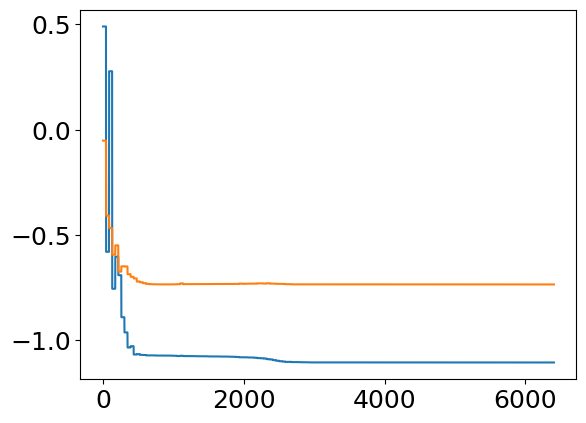

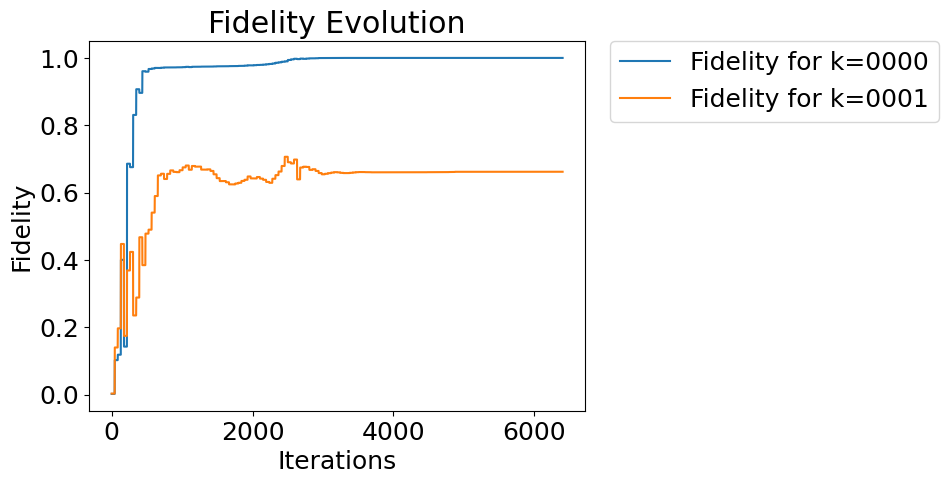

In [64]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from numpy import binary_repr
from qat.qpus import get_default_qpu

qpu = get_default_qpu()
method = "BFGS"



energy_lists = {f"energy_circ_{i}": {method: []} for i in range(len(circuits_store))}
fidelity_lists = {f"fidelity_circ_{i}": {method: []} for i in range(len(circuits_store))}

def opt_funct(circuits, model, qpu, nqbits, energy_lists, fidelity_lists, weight):
    def input_funct(x):
        total_energy = 0
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            result = qpu.submit(bound_circ.to_job(observable=model))
            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)

            # Calculate fidelity
            fidelity = fun_fidelity(bound_circ, eigenvec_input[i], nqbits)
            fidelity_lists[f"fidelity_circ_{i}"][method].append(fidelity)
            #print(fidelity)

            total_energy += weight[i] * energy
        return total_energy

    def callback(x):
        for i, circ in enumerate(circuits):
            bound_circ = circ.bind_variables({k: v for k, v in zip(sorted(circ.get_variables()), x)})
            result = qpu.submit(bound_circ.to_job(observable=model))
            energy = result.value
            energy_lists[f"energy_circ_{i}"][method].append(energy)

            # Calculate fidelity
            fidelity = fun_fidelity(bound_circ, eigenvec_input[i], nqbits)
            fidelity_lists[f"fidelity_circ_{i}"][method].append(fidelity)

    return input_funct, callback

input_funct, callback = opt_funct(circuits_store, model, qpu, nqbits, energy_lists, fidelity_lists, weight)
options = {"disp": True, "maxiter": 500, "gtol": 1e-7}

Optimizer = scipy.optimize.minimize(input_funct, x0=init_theta_list, method=method, callback=callback, options=options)

# Plot energy
plt.rcParams["font.size"] = 18
all_energy_lists = []

for i in range(len(circuits_store)):
    energy_list = energy_lists[f"energy_circ_{i}"][method]
    all_energy_lists.append(energy_list)
    plt.plot(range(len(energy_list)), energy_list, label=f"Energy for k={binary_repr(k_lst[i]).zfill(4)}")

    # Print the final energy for each k
    final_energy = energy_list[-1]
    print(f"Final energy for k={binary_repr(k_lst[i]).zfill(4)}: {final_energy}")

# Plot fidelity
plt.figure()
all_fidelity_lists = []

for i in range(len(circuits_store)):
    fidelity_list = fidelity_lists[f"fidelity_circ_{i}"][method]
    all_fidelity_lists.append(fidelity_list)
    plt.plot(range(len(fidelity_list)), fidelity_list, label=f"Fidelity for k={binary_repr(k_lst[i]).zfill(4)}")

    # Print the final fidelity for each k
    final_fidelity = fidelity_list[-1]
    print(f"Final fidelity for k={binary_repr(k_lst[i]).zfill(4)}: {final_fidelity}")

plt.xlabel("Iterations")
plt.ylabel("Fidelity")
plt.title("Fidelity Evolution")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.show()
